In [4]:
import pandas as pd
from pathlib import Path

In [17]:
DATA_PATH = Path('../data')
!ls {DATA_PATH}

test-jpg.tar.7z		      train-jpg.tar	train-tif-v2.tar.1
test-tif-v2.tar.7z	      train-jpg.tar.7z	train-tif-v2.tar.7z
test_v2_file_mapping.csv.zip  train-tif-v2	train_v2.csv
train-jpg		      train-tif-v2.tar	train_v2.csv.zip


In [18]:
!ls {DATA_PATH/'train-jpg'} | head

train_0.jpg
train_10000.jpg
train_10001.jpg
train_10002.jpg
train_10003.jpg
train_10004.jpg
train_10005.jpg
train_10006.jpg
train_10007.jpg
train_10008.jpg
ls: write error: Broken pipe


In [21]:
!ls {DATA_PATH/'train-jpg'} | wc -l

40479


In [19]:
!ls {DATA_PATH/'train-tif-v2'} | head

train_10001.tif
train_10002.tif
train_10003.tif
train_10006.tif
train_10008.tif
train_1000.tif
train_10010.tif
train_10011.tif
train_10012.tif
train_10014.tif
ls: write error: Broken pipe


In [22]:
!ls {DATA_PATH/'train-tif-v2'} | wc -l

25962


##### Check if some data is missing from the download files

In [15]:
csv = pd.read_csv(DATA_PATH/'train_v2.csv/train_v2.csv')

In [16]:
csv.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [23]:
csv.shape

(40479, 2)

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image

from sklearn.preprocessing import MultiLabelBinarizer

class PlanetDataset(Dataset):
    def __init__(self, csv_path, img_folder, ext, transform):
        self.img_folder = img_folder
        self.ext = ext
        self.csv = pd.read_csv(csv_path)[:100]
        self.mlb = MultiLabelBinarizer()
        self.transform = transform
        
        self.x_train = self.csv['image_name']
        self.y_train = self.mlb.fit_transform(self.csv['tags'].str.split())
    
    def __len__(self):
        return self.csv.shape[0]
    
    def __getitem__(self, idx):
        x = self.transform(Image.open(f'{self.img_folder}/{self.x_train[idx]}.{self.ext}').convert('RGB'))
        y = self.y_train[idx]
        
        return (x, y)

In [161]:
CSV_PATH = DATA_PATH/'train_v2.csv/train_v2.csv'
IMG_FOLDER = DATA_PATH/'train-jpg'
EXT = 'jpg'

In [182]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

ds = PlanetDataset(CSV_PATH, IMG_FOLDER, EXT, transform)

In [183]:
len(ds)

100

In [184]:
import matplotlib.pyplot as plt
%matplotlib inline

In [185]:
sample, label = ds[1]
sample.shape

torch.Size([3, 224, 224])

In [186]:
label, ds.mlb.classes_

(array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]),
 array(['agriculture', 'artisinal_mine', 'bare_ground', 'blooming',
        'clear', 'cloudy', 'conventional_mine', 'cultivation',
        'habitation', 'haze', 'partly_cloudy', 'primary', 'road',
        'slash_burn', 'water'], dtype=object))

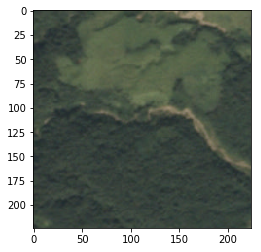

In [187]:
plt.imshow(sample.permute(2, 1, 0).numpy())

In [188]:
dl = DataLoader(ds, batch_size=10, shuffle=False, drop_last=True)

In [189]:
for x, y in dl:
    print(x.shape, y.shape)

torch.Size([10, 3, 224, 224]) torch.Size([10, 15])
torch.Size([10, 3, 224, 224]) torch.Size([10, 15])
torch.Size([10, 3, 224, 224]) torch.Size([10, 15])
torch.Size([10, 3, 224, 224]) torch.Size([10, 15])
torch.Size([10, 3, 224, 224]) torch.Size([10, 15])
torch.Size([10, 3, 224, 224]) torch.Size([10, 15])
torch.Size([10, 3, 224, 224]) torch.Size([10, 15])
torch.Size([10, 3, 224, 224]) torch.Size([10, 15])
torch.Size([10, 3, 224, 224]) torch.Size([10, 15])
torch.Size([10, 3, 224, 224]) torch.Size([10, 15])


In [190]:
len(ds.mlb.classes_)

15

#### Create a validation set

In [21]:
import pandas as pd

In [22]:
csv = pd.read_csv('../data/train_v2.csv/train_v2.csv')

In [23]:
csv.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [31]:
from sklearn.model_selection import train_test_split

In [32]:
train, val = train_test_split(csv, test_size=0.2, random_state=42)

In [33]:
train.shape

(32383, 2)

In [35]:
val.shape

(8096, 2)

In [36]:
train.head()

,image_name,tags
16634,train_16634,clear primary water
6316,train_6316,clear primary
4592,train_4592,cloudy
26146,train_26146,agriculture haze primary water
14189,train_14189,partly_cloudy primary


In [38]:
val.head()

,image_name,tags
34602,train_34602,clear primary road
11243,train_11243,clear primary water
14499,train_14499,clear conventional_mine habitation primary roa...
18918,train_18918,cloudy
30631,train_30631,agriculture clear cultivation cultivation habi...


In [39]:
train.to_csv('../data/train_v2.csv/train.csv', index=False)
val.to_csv('../data/train_v2.csv/val.csv', index=False)